In [8]:
import warnings
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import re
import sys
import os
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
import contextily as cx
import geopandas
import rasterio
from rasterio.plot import show as rioshow
from geodatasets import get_path
import imageio

warnings.simplefilter(action='ignore', category=FutureWarning)
sys.path.insert(0, '../')

# Lecture des données

In [9]:
FEATURES = ['duration', 'max_intensity', 'mean_intensity', 'variance', 'percentage_null']
pd.set_option('display.float_format', lambda x: '%.5f' % x)


In [10]:
df = pd.read_pickle("../data/dataframes/2018_07.pkl")
df['end_time_absolute'] = df['start_time_absolute'] + df['duration'] # should be removed in the future (newly generated .pkl files will already have this column)

In [11]:
df[FEATURES].describe()

,duration,max_intensity,mean_intensity,variance,percentage_null
count,2541934.00000,2541934.00000,2541934.00000,2541934.00000,2541934.00000
mean,7.63217,4.56716,1.49890,17.94690,0.01684
std,11.49736,12.73529,3.41503,133.53021,0.05453
min,1.00000,0.12000,0.06000,0.00000,0.00000
25%,2.00000,0.36000,0.24000,0.00000,0.00000
50%,4.00000,0.72000,0.48000,0.03840,0.00000
75%,8.00000,2.64000,1.17333,0.62493,0.00000
max,149.00000,323.64000,102.85571,12132.39542,0.50000


## Analyse des séries temporelles

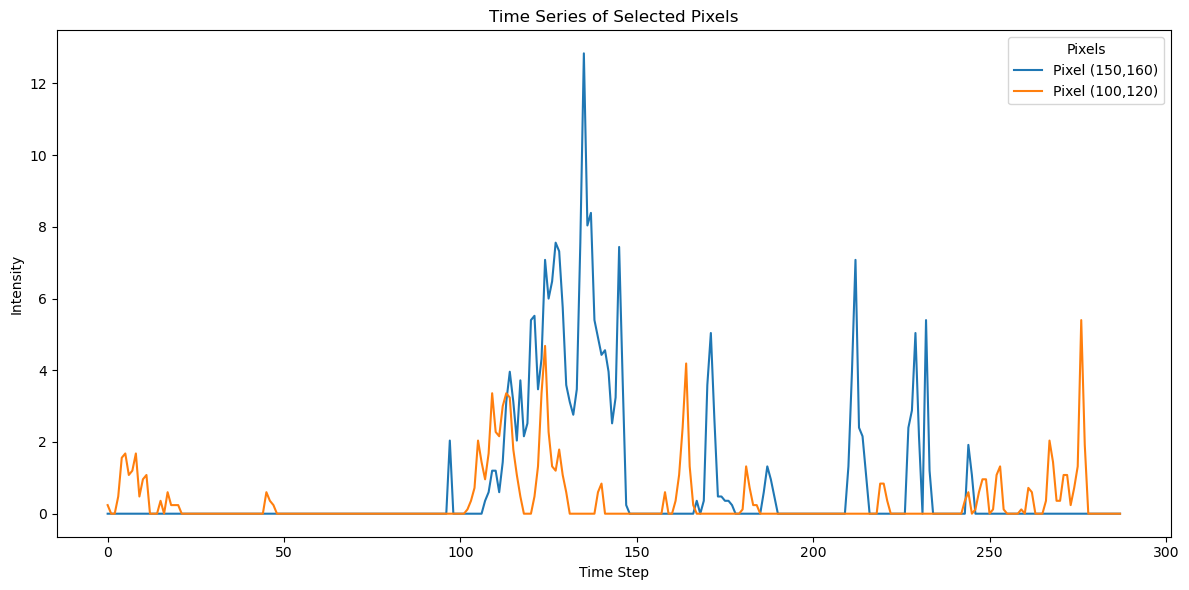

In [12]:
from src.utils import read_data
data = read_data(2018, 1, 1)

def create_pixel_time_series(data, pixel_coords):
    """Extract time series for specific pixels and convert to DataFrame."""
    time_series_data = {'Time Step': np.arange(data.shape[0])}
    for (x, y) in pixel_coords:
        time_series_data[f'Pixel ({x},{y})'] = data[:, x, y]
    return pd.DataFrame(time_series_data)

# Choose pixels to analyze
pixel_coords = [(150, 160), (100, 120)]  # Add more as needed

# Convert data to DataFrame
df_pixel_data = create_pixel_time_series(data, pixel_coords)

# Melt the DataFrame to long format
df_long = df_pixel_data.melt(id_vars=['Time Step'], var_name='Pixel', value_name='Intensity')

# Plotting
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_long, x='Time Step', y='Intensity', hue='Pixel')
plt.title('Time Series of Selected Pixels')
plt.ylabel('Intensity')
plt.legend(title='Pixels')
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
from scipy.signal import convolve

def convolve_grid(data, new_size=20):
    # Define the size of the new grid and the kernel based on the desired new size
    kernel_size = data.shape[1] // new_size  # Assuming data is square and divisible by new_size
    kernel = np.ones((kernel_size, kernel_size)) / (kernel_size ** 2)
    
    # Initialize an array to hold the convolved data
    convolved_data = np.empty((data.shape[0], new_size, new_size))
    
    # Perform convolution for each time step
    for t in range(data.shape[0]):
        convolved_data[t] = convolve(data[t], kernel, mode='valid')[::kernel_size, ::kernel_size]
    
    return convolved_data

# Assuming 'data' is your 3D array with dimensions (time_steps, 300, 300)
convolved_data = convolve_grid(data)


## Analyse des features

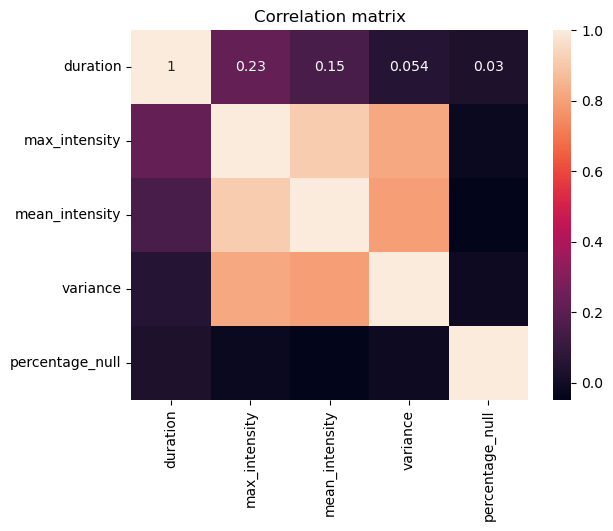

In [14]:
correlation_matrix = df[FEATURES].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation matrix')
plt.show()

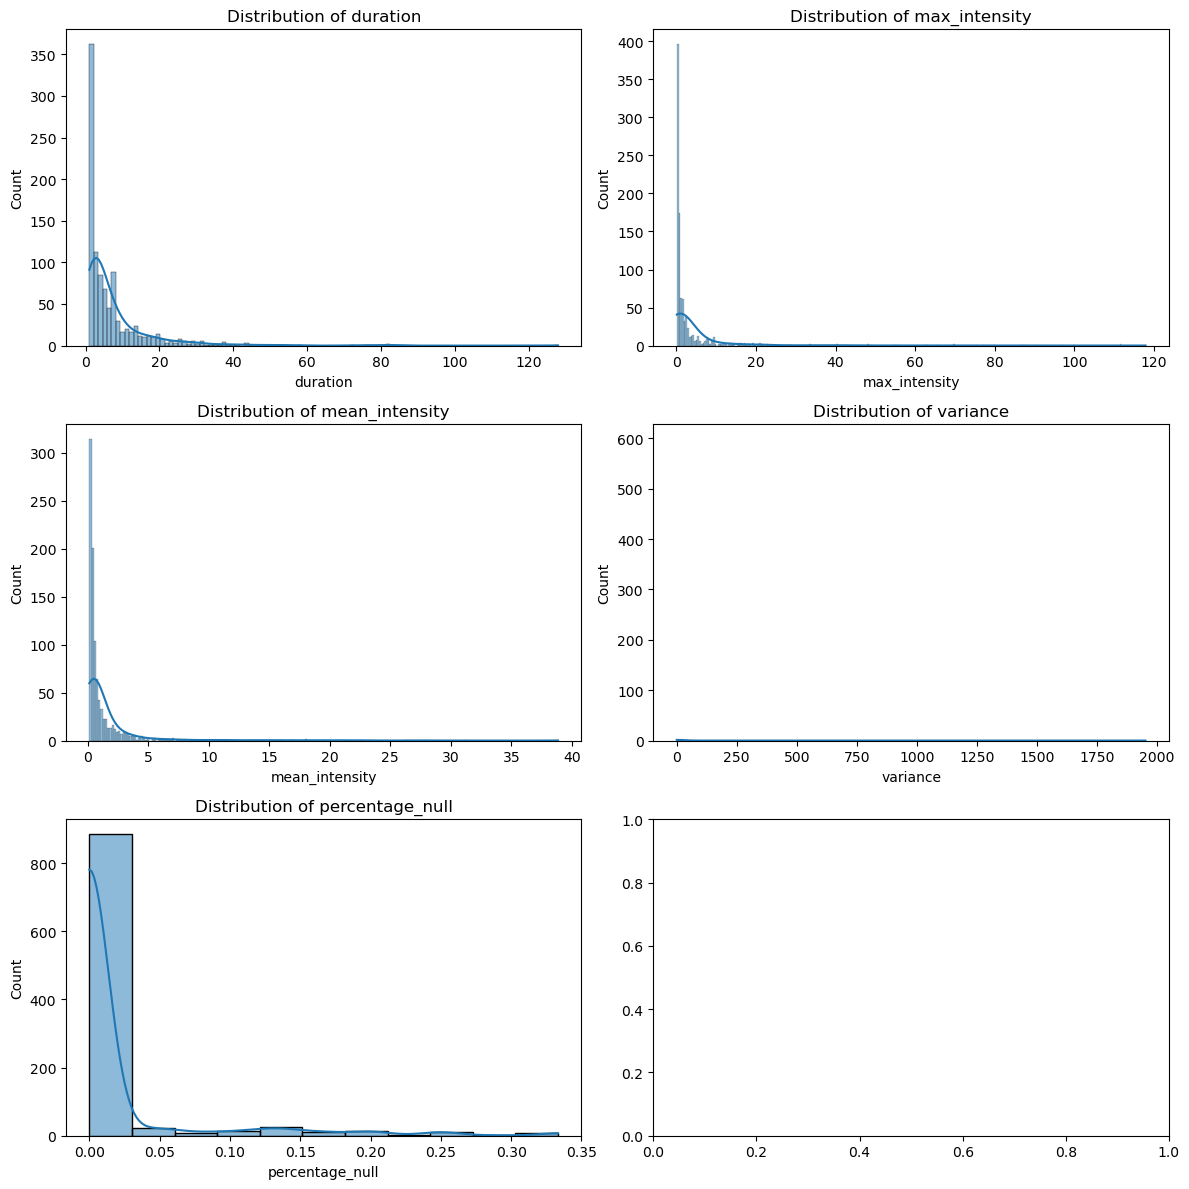

In [15]:
# distribution of the features. in one plot

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

df_sample = df.sample(1000)

for i, feature in enumerate(FEATURES):
    sns.histplot(df_sample[feature], ax=axes[i//2, i%2], kde=True)
    axes[i//2, i%2].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

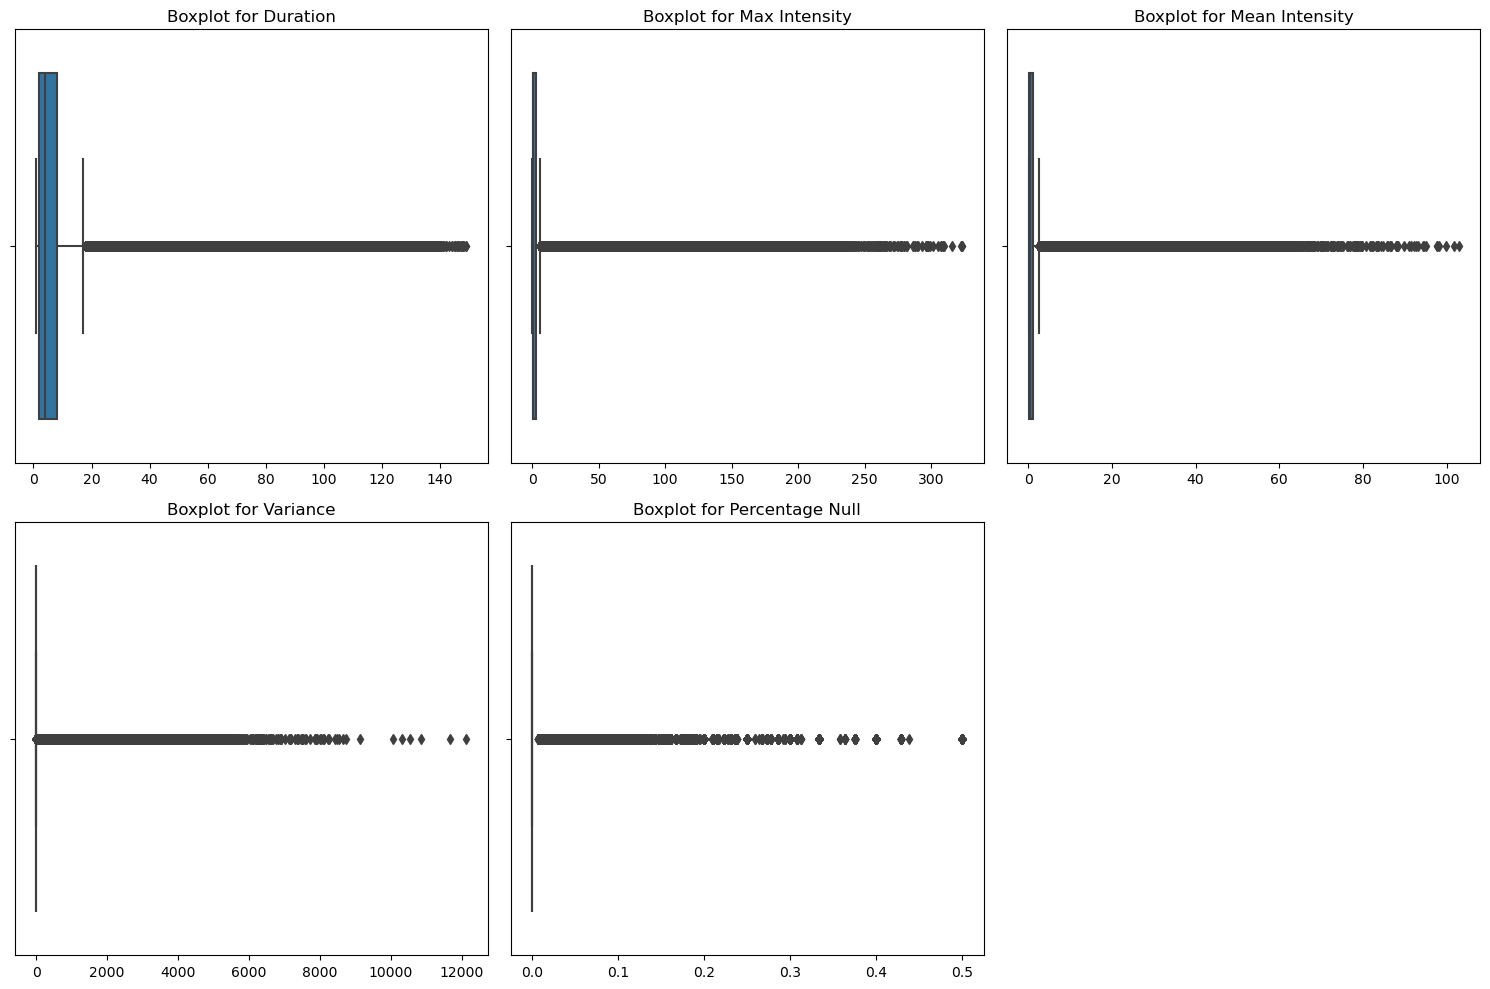

In [35]:
# Set up the matplotlib figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # Adjust the size as needed

# List of columns and titles
features = ['duration', 'max_intensity', 'mean_intensity', 'variance', 'percentage_null']
titles = ['Duration', 'Max Intensity', 'Mean Intensity', 'Variance', 'Percentage Null']

# Iterate over features and titles to create subplots
for ax, feature, title in zip(axes.flatten(), features, titles):
    sns.boxplot(x=df[feature], ax=ax)
    ax.set_title(f'Boxplot for {title}')
    ax.set_xlabel('')  # Remove x-axis label if preferred

# Hide the last (empty) subplot if the number of plots is not a perfect match for the grid
if len(features) < len(axes.flatten()):
    axes.flatten()[-1].set_visible(False)

plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area
plt.show()


In [20]:
import numpy as np
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColorBar, LinearColorMapper
from bokeh.palettes import Viridis256
from bokeh.layouts import column
from src.utils import GRID_SIZE, TIME_STEPS_PER_DAY

# Assuming 'data' is your 3D array (num_days, GRID_SIZE, GRID_SIZE)
# You might load this from your utilities or directly as shown below
# data = np.random.rand(num_days, GRID_SIZE, GRID_SIZE)  # Example placeholder

num_days = data.shape[0]  # Assuming 'data' is structured as (num_days, GRID_SIZE, GRID_SIZE)

output_file("rain_intensity_heatmap.html")

# Create a color mapper
mapper = LinearColorMapper(palette=Viridis256, low=data.min(), high=data.max())

# Create a list of heatmap plots
heatmaps = []
for day in range(num_days):
    # Create a heatmap plot for the current day
    heatmap = figure(x_range=(0, GRID_SIZE), y_range=(0, GRID_SIZE),
                     tools="hover,pan,wheel_zoom,reset",
                     tooltips=[("Row", "$y"), ("Column", "$x"), ("Intensity", "@image{0.00}")],  # Formatting Intensity
                     title=f"Day {day+1}")

    # Create the heatmap renderer
    heatmap.image(image=[data[day]], x=0, y=0, dw=GRID_SIZE, dh=GRID_SIZE, color_mapper=mapper)

    # Add a color bar
    color_bar = ColorBar(color_mapper=mapper, location=(0, 0))
    heatmap.add_layout(color_bar, 'right')

    # Add hover tool settings
    hover = heatmap.select_one(HoverTool)
    hover.tooltips = [("Row", "$y"), ("Column", "$x"), ("Intensity", "@image{0.00}")]

    # Add the heatmap to the list
    heatmaps.append(heatmap)

# Create a layout to display all heatmaps
layout = column(*heatmaps)  # Unpack the list to individual elements

# Display the layout
show(layout)


# Clustering

In [27]:
df

,year,month,day,i,j,start_time_relative,start_time_absolute,duration,max_intensity,mean_intensity,variance,percentage_null,end_time_absolute
0,2018,7,1,0,0,213,213,2,0.12000,0.12000,0.00000,0.00000,215
1,2018,7,1,0,1,212,212,2,0.12000,0.12000,0.00000,0.00000,214
2,2018,7,1,0,2,212,212,2,0.12000,0.12000,0.00000,0.00000,214
3,2018,7,1,0,3,212,212,1,0.12000,0.12000,0.00000,0.00000,213
4,2018,7,1,0,4,211,211,1,0.12000,0.12000,0.00000,0.00000,212
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541929,2018,7,31,299,298,213,8853,5,0.60000,0.28800,0.04954,0.20000,8858
2541930,2018,7,31,299,298,224,8864,8,1.20000,0.70500,0.06277,0.00000,8872
2541931,2018,7,31,299,299,199,8839,1,0.36000,0.36000,0.00000,0.00000,8840
2541932,2018,7,31,299,299,215,8855,3,0.60000,0.40000,0.02240,0.00000,8858


In [28]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('clustering', KMeans(n_clusters=3, random_state=42))  # Adjust n_clusters as needed
])

df['cluster'] = pipeline.fit_predict(df[FEATURES])


In [32]:
# Create a datetime index
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('date', inplace=True)

# Aggregate data by date and cluster (example: average max_intensity per day for each cluster)
cluster_time_series = df.groupby(['date', 'cluster'])['max_intensity'].mean().unstack()


C:\Users\Benjamin\AppData\Local\Temp\ipykernel_19820\4080085352.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['date'] = pd.to_datetime(region_df[['year', 'month', 'day']])


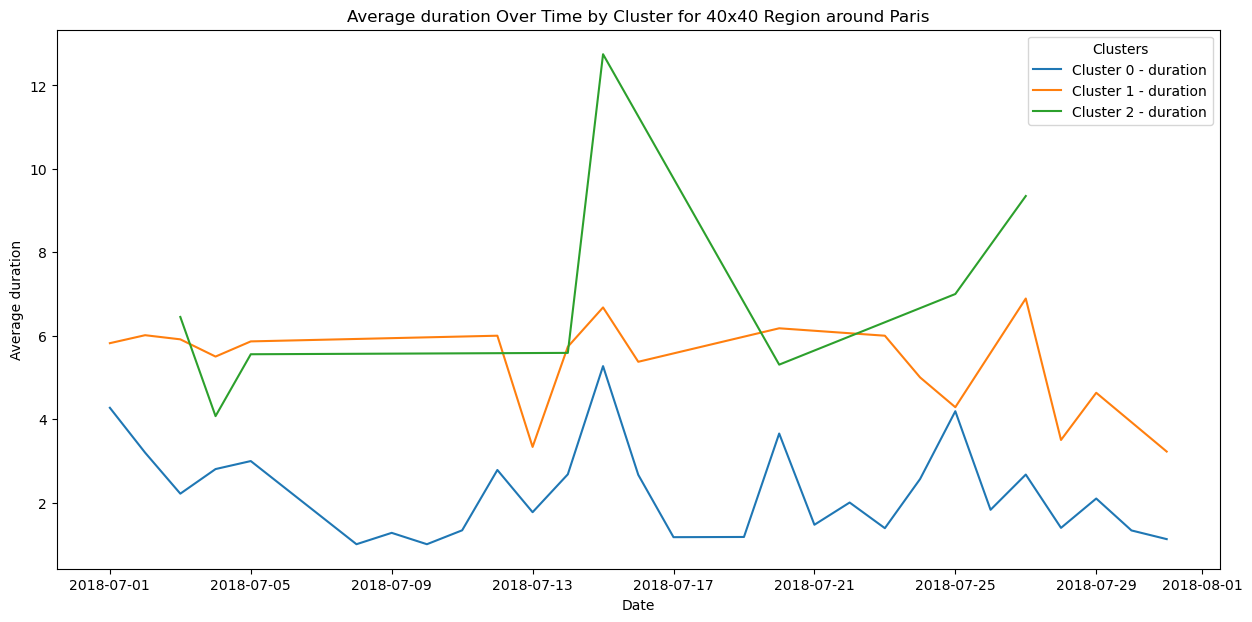

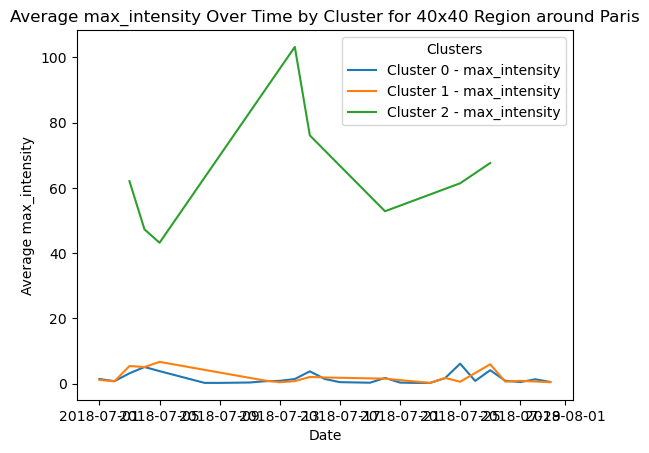

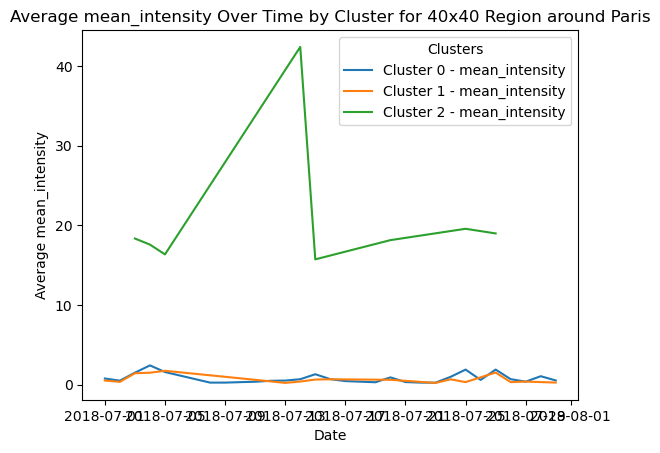

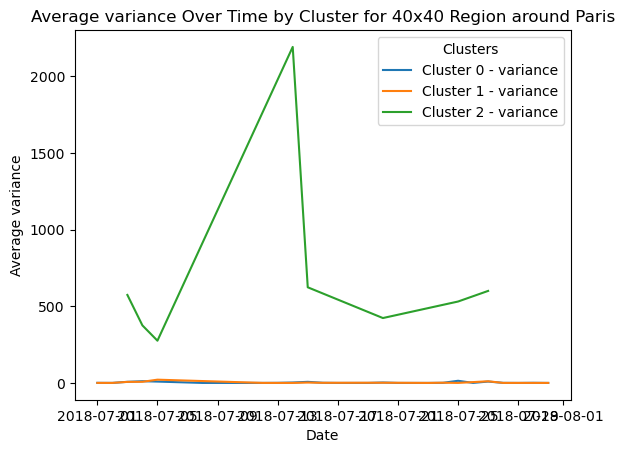

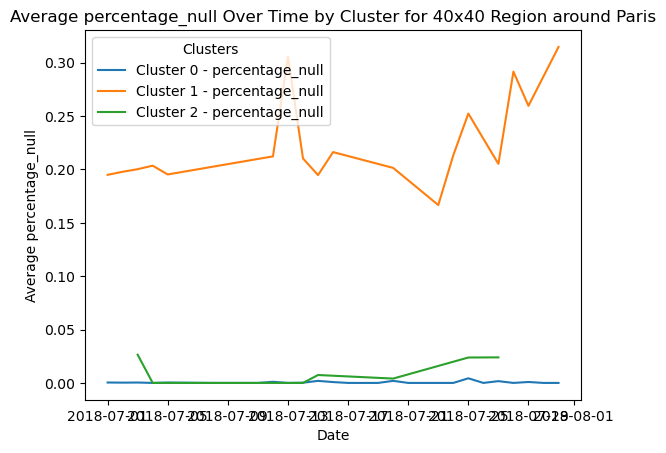

In [43]:
# Assuming GRID_SIZE is still 300 (from previous context)
center_i, center_j = GRID_SIZE // 2, GRID_SIZE // 2  # Find the center
half_window = 20  # Half the size of the region we're interested in

# Define the boundaries of the 30x30 region around the center
start_i, end_i = center_i - half_window, center_i + half_window
start_j, end_j = center_j - half_window, center_j + half_window

# Filter the DataFrame for this region
region_df = df[(df['i'] >= start_i) & (df['i'] < end_i) & (df['j'] >= start_j) & (df['j'] < end_j)]

# Create a datetime index for aggregation
region_df['date'] = pd.to_datetime(region_df[['year', 'month', 'day']])
region_df.set_index('date', inplace=True)

# Aggregate data by date and cluster (example: average max_intensity per day for each cluster)
features = ['duration', 'max_intensity', 'mean_intensity', 'variance', 'percentage_null']
cluster_time_series = region_df.groupby(['date', 'cluster'])[features].mean().unstack(level=-1)

# Initialize the figure
plt.figure(figsize=[15, 7])

# Loop through each feature you want to plot
for feature in FEATURES:
    # Plot each cluster's time series
    for cluster in cluster_time_series[feature].columns:
        sns.lineplot(data=cluster_time_series[feature][cluster], label=f'Cluster {cluster} - {feature}')

    plt.title(f'Average {feature} Over Time by Cluster for 40x40 Region around Paris')
    plt.xlabel('Date')
    plt.ylabel(f'Average {feature}')
    plt.legend(title='Clusters')
    plt.show()



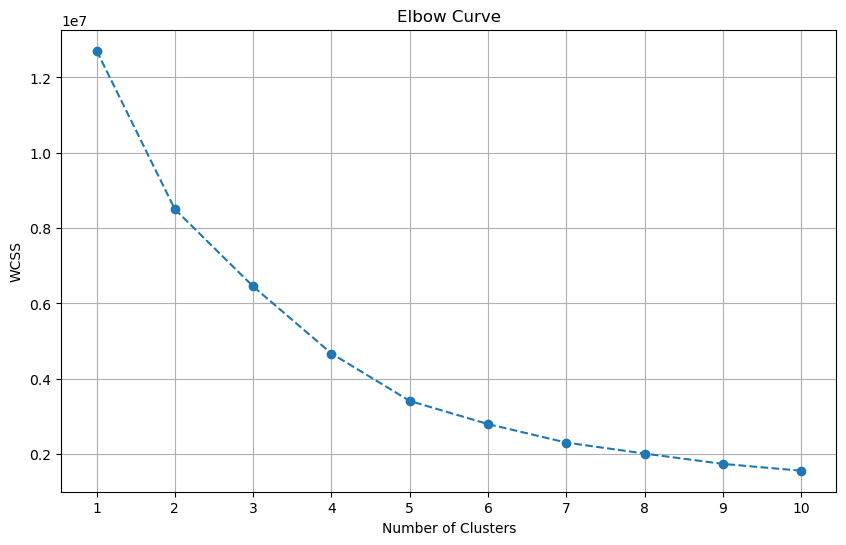

In [24]:
X = df[FEATURES] # features of interest

wcss = []
cluster_range = range(1, 11)  # Adjust the range based on your needs

for n_clusters in cluster_range:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42))
    ])

    pipeline.fit(X)

    wcss.append(pipeline.named_steps['kmeans'].inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

In [20]:
df_sample = df.sample(10000)[['duration','max_intensity', 'mean_intensity', 'variance', 'percentage_null', 'label']]

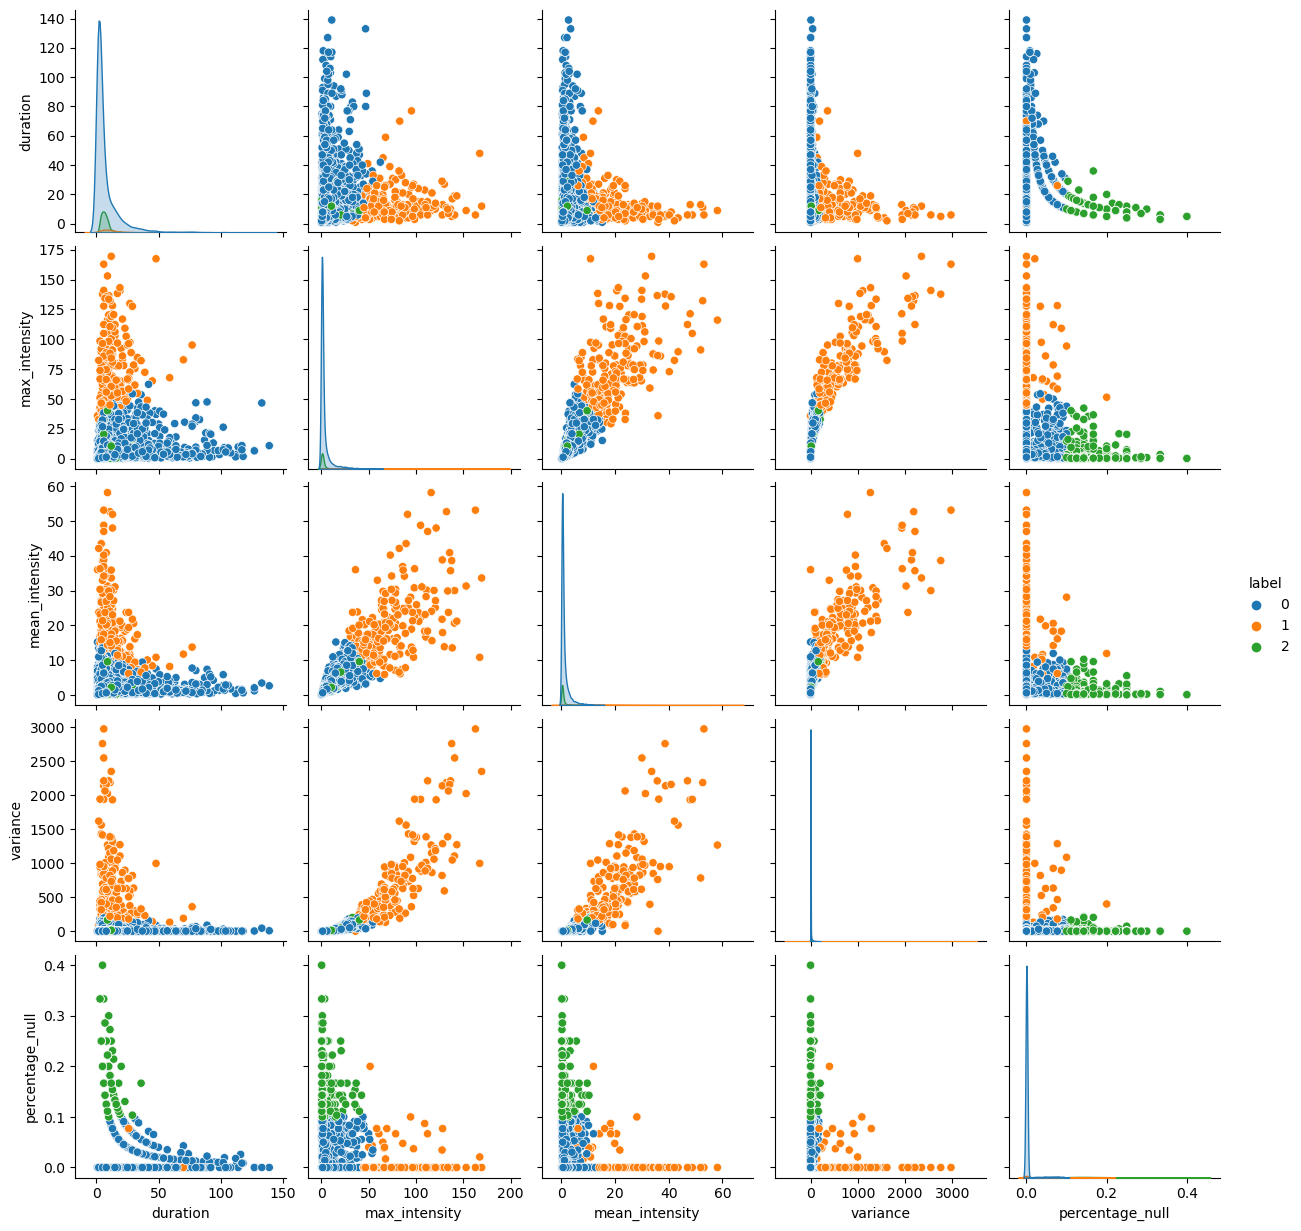

In [21]:
g = sns.pairplot(df_sample, hue="label", vars=FEATURES, palette='tab10')

Distributions

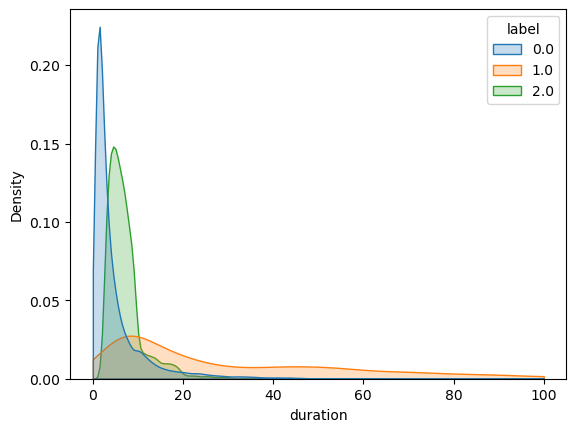

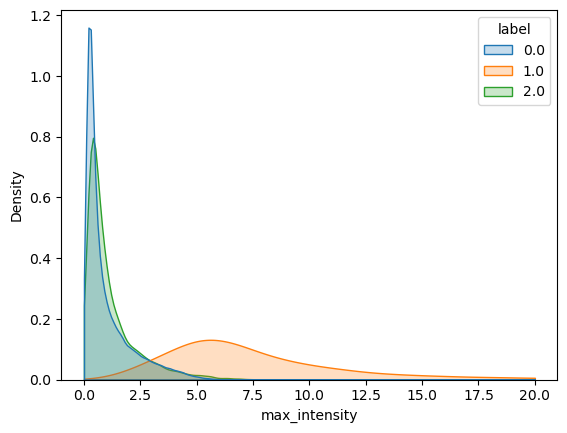

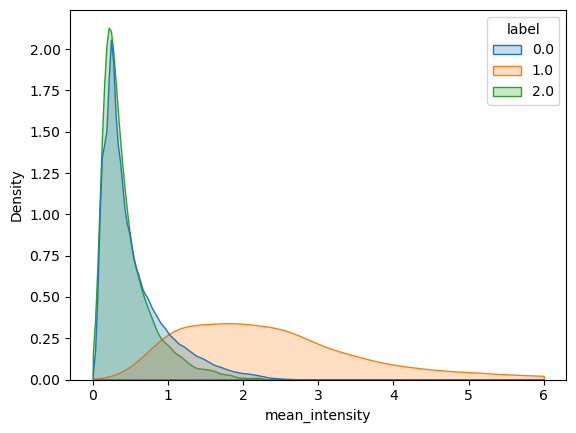

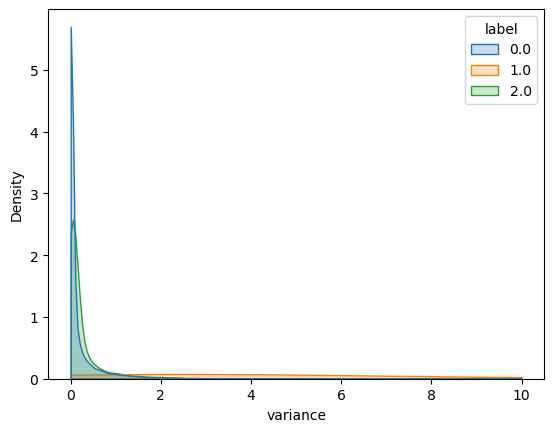

<Axes: xlabel='percentage_null', ylabel='Density'>

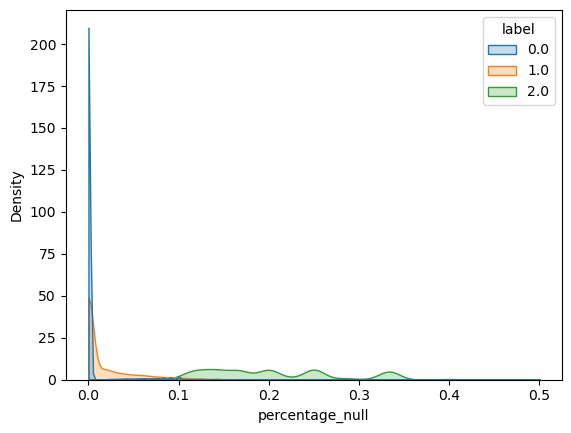

In [67]:
df_sample = df.sample(10000)

sns.kdeplot(data=df_sample, x="duration", hue='label', fill=True, common_norm=False, common_grid=True, palette='tab10', clip=(0, 100))
plt.show()
sns.kdeplot(data=df_sample, x="max_intensity", hue='label', fill=True, common_norm=False, common_grid=True, palette='tab10', clip=(0, 20))
plt.show()
sns.kdeplot(data=df_sample, x="mean_intensity", hue='label', fill=True, common_norm=False, common_grid=True, palette='tab10', clip=(0, 6))
plt.show()
sns.kdeplot(data=df_sample, x="variance", hue='label', fill=True, common_norm=False, common_grid=True, palette='tab10', clip=(0, 10))
plt.show()
sns.kdeplot(data=df_sample, x="percentage_null", hue='label', fill=True, common_norm=False, common_grid=True, palette='tab10', clip=(0, 0.5))

# Visualisation

In [23]:
# get first day of january
events_sample = df[df['day'] == 1]

In [ ]:
# creates a background image of the 300x300 grid around Paris
# don't plot anything inline

west, south, east, north = (
    0.2986403353389431,
    47.502048648648646,
    4.398959664661057,
    50.204751351351355
)

paris_img, paris_ext = cx.bounds2img(west,
                                     south,
                                     east,
                                     north,
                                     ll=True,
                                     source=cx.providers.CartoDB.Voyager
                                    )

f, ax = plt.subplots(1, figsize=(9, 9))
# remove legend
ax.get_xaxis().set_visible(False)
# remove axis scale
ax.get_yaxis().set_visible(False)
#save picture to background.png
plt.savefig('images/background.png', bbox_inches='tight', pad_inches=0)

In [33]:
# Create a scatter plot of the clustered events for each time step of the first day of January 2018
# Each frame will be saved as a PNG file, and later assembled into a GIF

length = 288
time_step = 1 # lowest
plt.figure(figsize=(10, 10))

# Create a legend manually
labels_unique = events_sample['label'].unique()
legend_elements = [mlines.Line2D([], [], marker='o', color=sns.color_palette('Set2', n_colors=N_CLUSTERS)[i], label=str(label), markersize=10, linestyle='None') for i, label in enumerate(labels_unique)]

# Create a separate legend figure
legend_fig, legend_ax = plt.subplots(figsize=(4, 2))
legend_ax.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, 0.5), ncol=len(labels_unique))
legend_ax.axis('off')
legend_fig.savefig('images/legend.png', bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(legend_fig)

# Load the legend image
legend_img = plt.imread('images/legend.png')
# Load background image
background_img = plt.imread('images/background.png')

# Determine the extent of the data
x_min, x_max = events_sample['i'].min(), events_sample['i'].max()
y_min, y_max = events_sample['j'].min(), events_sample['j'].max()
x_padding = 0.001 * (x_max - x_min)
y_padding = 0.001 * (y_max - y_min)

legend_x_offset = 460  # Adjust this based on your figure's layout
legend_y_offset = 660  # Adjust this based on your figure's layout

# Animate the scatter plot and save each frame as a PNG
for t in range(0, length, time_step):
    currents_events = events_sample[(events_sample['start_time_absolute'] <= t) & (t <= events_sample['end_time_absolute'])]
    plt.figure(figsize=(10, 10))  # Moved inside the loop to ensure clean slate
    plt.gca().set_aspect('equal')
    sns.scatterplot(data=currents_events, x='i', y='j', hue='label', alpha=0.8, s=3, palette=sns.color_palette('Set2', n_colors=N_CLUSTERS), legend=False)
    
    # Set the x and y limits based on the extent of the data
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

    # Overlay the background image correctly
    plt.imshow(background_img, aspect='equal', extent=[x_min - x_padding, x_max + x_padding, y_min - y_padding, y_max + y_padding], zorder=0)

    # Overlay the legend image; adjust coordinates as necessary
    fig = plt.gcf()
    # Note: Adjust coordinates as necessary to place the legend correctly
    fig.figimage(legend_img, xo=legend_x_offset, yo=legend_y_offset, zorder=9, alpha=1)  # Change xo, yo values based on your layout

    # Remove the tickers
    plt.xticks([])
    plt.yticks([])
    
    # Remove the axis
    plt.axis('off')
    
    plt.savefig(f'images/kmeans_{t}.png', bbox_inches='tight', pad_inches=0)
    plt.close()  # Close the figure to free up memory and start fresh for the next frame

<Figure size 1000x1000 with 0 Axes>

In [34]:
# Combine into a GIF
# create a list of all the files in the directory

files = os.listdir('images')
files = [file for file in files if re.search(r'kmeans_\d+.png', file)]
files.sort(key=lambda x: int(re.search(r'kmeans_(\d+).png', x).group(1)))

# create a list of images, without imageio
images = []
for file in files:
    images.append(imageio.imread("images/"+file))

# save the gif
imageio.mimsave('kmeans_3_map.gif', images, duration=0.5, loop=0)

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_22152\2902912560.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread("images/"+file))


In [ ]:
# Plot the raw data of the first day of January 2018 over the background image of Paris

first_day = get_matrix(2018, 1, 1)

length = first_day.shape[0]  # Adjusted to match the first_day shape
time_step = 1 # lowest
plt.figure(figsize=(10, 10))
# Determine the extent of the data
x_min, x_max = 0, first_day.shape[1]  # Adjusted to match the first_day shape
y_min, y_max = 0, first_day.shape[2]  # Adjusted to match the first_day shape
x_padding = 0.001 * (x_max - x_min)
y_padding = 0.001 * (y_max - y_min)

# Animate the scatter plot and save each frame as a PNG
for t in range(0, length, time_step):
    map = first_day[t].T  # Adjusted to match the first_day data
    plt.figure(figsize=(10, 10))  # Moved inside the loop to ensure clean slate
    plt.gca().set_aspect('equal')
    
    # Create a masked array where the mask is True for all "0" values
    map[map == 0] = np.nan
    
    sns.heatmap(map, cmap='viridis', alpha=0.6, cbar=False)  # Adjusted to use heatmap for matrix data
    
    # Set the x and y limits based on the extent of the data
    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

    # Overlay the background image correctly
    plt.imshow(background_img, aspect='equal', extent=[x_min - x_padding, x_max + x_padding, y_min - y_padding, y_max + y_padding], zorder=0)
    
    # Remove the tickers
    plt.xticks([])
    plt.yticks([])
    
    plt.savefig(f'tmp/first_day_{t}.png', bbox_inches='tight', pad_inches=0, dpi=100)
    plt.close()  # Close the figure to free up memory and start fresh for the next frame

In [ ]:
# Combine into a GIF

files = os.listdir('tmp')
files = [file for file in files if re.search(r'first_day_\d+.png', file)]
files.sort(key=lambda x: int(re.search(r'first_day_(\d+).png', x).group(1)))

# create a list of images, without imageio
images = []
for file in files:
    images.append(imageio.imread("tmp/"+file))

# save the gif
imageio.mimsave('firstday_raw.gif', images, duration=0.5, loop=0)